In [ ]:
%pip install gensim pandas openpyxl

In [ ]:
import pandas as pd

df = pd.read_excel('EnglishMaterial.xlsx', engine='openpyxl')
corpus = df['WORD'].dropna().tolist()  # Extract non-null text entries as a list

In [ ]:
### Prepare the data 
# Preprocess the text data 
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

# Tokenize each text entry
processed_corpus = [simple_preprocess(text) for text in corpus if isinstance(text, str)]

In [ ]:
### Train Word2Vec Model
# Train a Word2Vec model on the corpus
# Set training parameters
model = Word2Vec(sentences=processed_corpus, vector_size=100, window=5, min_count=1, workers=4)

model.save("word2vec_model.model")

word2vec_model = Word2Vec.load("word2vec_model.model")

In [ ]:
### Check Semantic Associations
# use cosine similarity between word vectors
word1 = "children"
word2 = "mirror"

if word1 in word2vec_model.wv and word2 in word2vec_model.wv:
    word1_vector = word2vec_model.wv[word1]
    word2_vector = word2vec_model.wv[word2]

    # Calculate cosine similarity
    from sklearn.metrics.pairwise import cosine_similarity
    similarity = cosine_similarity([word1_vector], [word2_vector])
    print(f"Cosine similarity between '{word1}' and '{word2}': {similarity[0][0]}")
else:
    print(f"One or both words ('{word1}', '{word2}') are not in the vocabulary.")

In [10]:
### Extract semantic associations for all vocabulary pairs
vocabulary = list(word2vec_model.wv.index_to_key)

# Create a dictionary to store the similarity 
semantic_associations = {}

# Iterate through all pairs of words
for i in range(len(vocabulary)):
    word1 = vocabulary[i]
    for j in range(i + 1, len(vocabulary)):
        word2 = vocabulary[j]
        similarity = word2vec_model.wv.similarity(word1, word2)
        semantic_associations[(word1, word2)] = similarity

# Check some sample of semantic associations
for key, value in list(semantic_associations.items())[:10]:
    print(f"Semantic similarity between '{key[0]}' and '{key[1]}': {value}")

Semantic similarity between 'the' and 'to': -0.010839169844985008
Semantic similarity between 'the' and 'of': -0.05234673619270325
Semantic similarity between 'the' and 'and': -0.111670583486557
Semantic similarity between 'the' and 'it': -0.02775036171078682
Semantic similarity between 'the' and 'that': -0.05987629294395447
Semantic similarity between 'the' and 'was': 0.01613469421863556
Semantic similarity between 'the' and 'you': 0.09291722625494003
Semantic similarity between 'the' and 'in': 0.027057476341724396
Semantic similarity between 'the' and 'he': 0.21616670489311218
Semantic similarity between 'the' and 'is': 0.06285078823566437


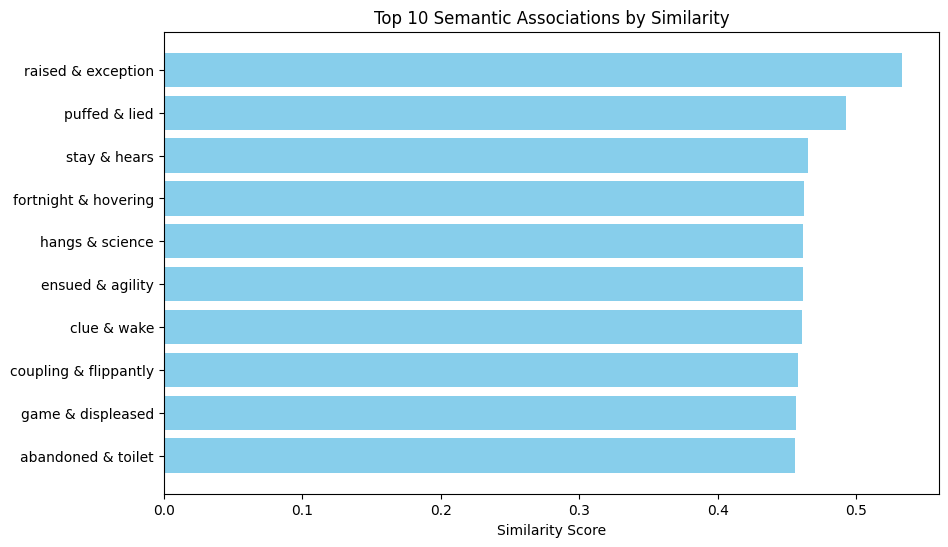

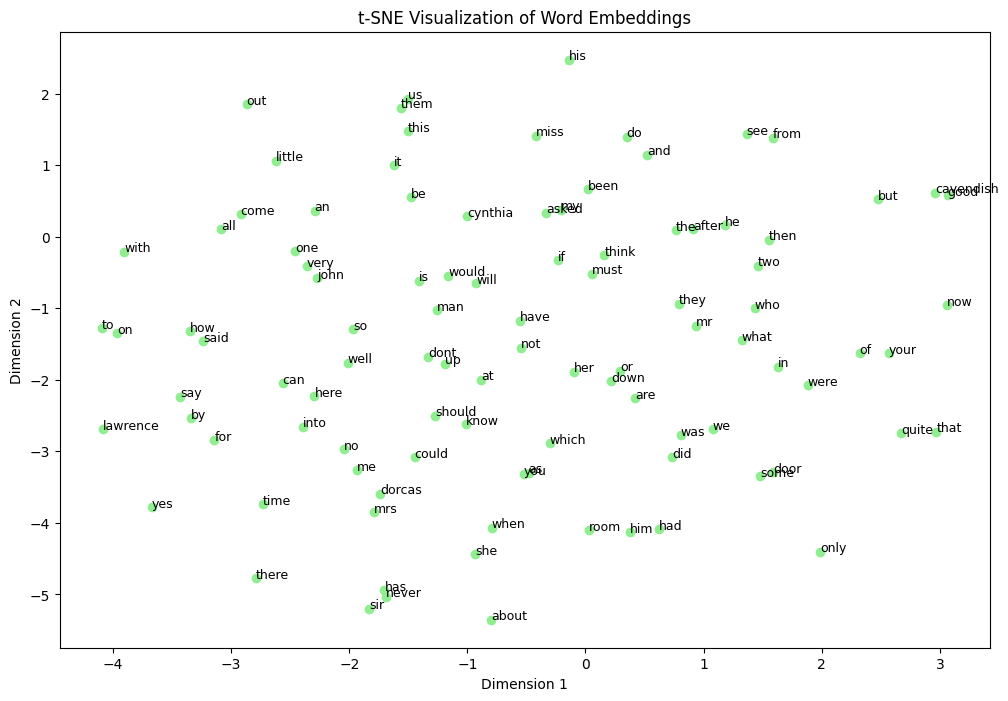

In [14]:
### Visualisation
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

### Barplot for pais

# Sort associations by similarity score
sorted_df = df_associations.sort_values(by="Similarity", ascending=False).head(10)

# Plot the top word pairs by similarity
plt.figure(figsize=(10, 6))
plt.barh(sorted_df["Word1"] + " & " + sorted_df["Word2"], sorted_df["Similarity"], color='skyblue')
plt.xlabel("Similarity Score")
plt.title("Top 10 Semantic Associations by Similarity")
plt.gca().invert_yaxis()  # Reverse the order for better visualization
plt.show()

### t-SNE plot
# Assuming 'model' is your trained Word2Vec model
words = list(model.wv.key_to_index.keys())[:100]  # Select a subset of words for visualization
word_vectors = model.wv[words]

# Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(word_vectors)

# Plot the word embeddings in 2D space
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='lightgreen')

# Annotate points with their corresponding words
for i, word in enumerate(words):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title("t-SNE Visualization of Word Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()



In [ ]:
### Convert to a dataframe 
df_associations = pd.DataFrame(list(semantic_associations.items()), columns=["Word Pair", "Similarity"])
df_associations[["Word1", "Word2"]] = pd.DataFrame(df_associations["Word Pair"].tolist(), index=df_associations.index)
df_associations.drop(columns=["Word Pair"], inplace=True)

print(df_associations.head())  
df_associations.to_csv("semantic_associations.csv", index=False)